In [1]:
# import necessary libraries

# 📦 Standard Library
import sys
from pathlib import Path
import os

# Data Science Libraries
import pandas as pd
import numpy  as np

# 🛠️ Project-Specific Modules
sys.path.append(str(Path().resolve().parent / "src"))
from paths import DOCS_DIR, INTERIM_DIR, RAW_DATA_DIR

# SQLAlchemy and SQLite for database operations
import sqlite3
from sqlite3 import Error
from sqlalchemy import create_engine, inspect

# Data preparation to work with SQLite

## Connection

In [4]:
# Delete the old database file if it exists
if os.path.exists("superstore_sql.db"):
    os.remove("superstore_sql.db")

In [2]:
# Create a fresh SQLite connection
conn = sqlite3.connect(RAW_DATA_DIR/"superstore_sql.db")
cursor = conn.cursor()


## Tables

In [3]:
# Create Tables
cursor.executescript('''             
-- Regions Table
CREATE TABLE Regions (
    RegionID INTEGER PRIMARY KEY AUTOINCREMENT,
    RegionName VARCHAR(50),
    State VARCHAR(50),
    City VARCHAR(100),
    PostalCode INT
);

-- Customers Table
CREATE TABLE Customers (
    CustomerID VARCHAR(20) PRIMARY KEY,
    CustomerName VARCHAR(100),
    Segment VARCHAR(50)
);

-- Customer Address Junction Table (This enables customers to have multiple addresses and vice versa )
CREATE TABLE CustomerAddress (
    CustomerID VARCHAR(20),
    RegionID INT,
    FOREIGN KEY (CustomerID) REFERENCES Customers(CustomerID),
    FOREIGN KEY (RegionID) REFERENCES Regions(RegionID),
    PRIMARY KEY (CustomerID, RegionID)
);                     
-- Categories Table
    CREATE TABLE Categories (
    CategoryID INTEGER PRIMARY KEY AUTOINCREMENT,
    CategoryName VARCHAR(50),
    SubCategoryName VARCHAR(50),
    CategoryCode VARCHAR(10) UNIQUE  
);

-- Products Table
CREATE TABLE Products (
    ProductID VARCHAR(20) PRIMARY KEY,
    ProductName VARCHAR(255),
    CategoryCode VARCHAR(10),
    FOREIGN KEY (CategoryCode) REFERENCES Categories(CategoryCode)
);

-- Shipping Table
CREATE TABLE Shipping (
    ShipID INTEGER PRIMARY KEY AUTOINCREMENT,
    ShipMode VARCHAR(50),
    ShipDate DATE
);

-- Orders Table
CREATE TABLE Orders (
    OrderID VARCHAR(20) PRIMARY KEY,
    OrderDate DATE,
    CustomerID VARCHAR(20),
    ShipID INT,
    FOREIGN KEY (CustomerID) REFERENCES Customers(CustomerID),
    FOREIGN KEY (ShipID) REFERENCES Shipping(ShipID)
);

-- Order Details Table
CREATE TABLE OrderDetails (
    OrderDetailID INTEGER PRIMARY KEY AUTOINCREMENT,
    OrderID VARCHAR(20),
    ProductID VARCHAR(20),
    Sales DECIMAL(10,2),
    Quantity INT,
    Discount DECIMAL(5,2),
    Profit DECIMAL(10,2),
    FOREIGN KEY (OrderID) REFERENCES Orders(OrderID),
    FOREIGN KEY (ProductID) REFERENCES Products(ProductID)
);
''')

# Commit and close connection
conn.commit()
conn.close()


## Populating the tables

### Load CSV and setup connection

In [4]:
# upload csv
superstore_df = pd.read_csv(RAW_DATA_DIR/"Sample-Superstore.csv", encoding = "latin1")

In [5]:
# Clean column names 
superstore_df.columns = superstore_df.columns.str.strip().str.replace(' ', '_')

#fixing date columns 
## convert Order Date and Ship Date to datetime format
superstore_df["Order_Date"] = pd.to_datetime(superstore_df["Order_Date"], format='mixed')
superstore_df["Ship_Date"] = pd.to_datetime(superstore_df["Ship_Date"], format='mixed')

## convert them back to string format for SQLite compatibility
superstore_df["Order_Date"] = superstore_df["Order_Date"].astype(str)
superstore_df["Ship_Date"] = superstore_df["Ship_Date"].astype(str)

## Drop Row ID since it doesnt have any meaningful role in relationships / prevent errors
superstore_df.drop(columns=["Row_ID"], inplace=True)

# Connect to SQLite
engine = create_engine("sqlite:///superstore_sql.db")

### Populate Regions

In [7]:
# Select distinct regions
regions_df = superstore_df[['Region', 'State', 'City', 'Postal_Code']].drop_duplicates()
regions_df = regions_df.rename(columns={
    'Region': 'RegionName', 
    'Postal_Code': 'PostalCode'
})
#connect to the database
conn = sqlite3.connect(RAW_DATA_DIR/"superstore_sql.db")
# Insert into table
regions_df.to_sql('Regions', conn, if_exists='append', index=False)

# Fetch with RegionID
regions_sql = pd.read_sql_query("SELECT * FROM Regions", conn)


In [8]:
# visualize the regions table
regions_sql

,RegionID,RegionName,State,City,PostalCode
0,1,South,Kentucky,Henderson,42420
1,2,West,California,Los Angeles,90036
2,3,South,Florida,Fort Lauderdale,33311
3,4,West,California,Los Angeles,90032
4,5,South,North Carolina,Concord,28027
...,...,...,...,...,...
627,628,South,Arkansas,Springdale,72762
628,629,West,California,Lodi,95240
629,630,Central,Texas,La Porte,77571
630,631,East,Ohio,Mason,45040


### Populate Customers

In [9]:
customers_df = superstore_df[['Customer_ID', 'Customer_Name', 'Segment']].drop_duplicates()
customers_df = customers_df.rename(columns={
    'Customer_ID': 'CustomerID',
    'Customer_Name': 'CustomerName'
})

customers_df.to_sql('Customers', conn, if_exists='append', index=False)

793

### Populate Customer Address (junction)

In [10]:
# Prepare region lookup
region_lookup = pd.read_sql_query("SELECT RegionID, RegionName, State, City, PostalCode FROM Regions", conn)

# Merge to get RegionID
customer_address_df = superstore_df[['Customer_ID', 'Region', 'State', 'City', 'Postal_Code']].drop_duplicates()
customer_address_df = customer_address_df.rename(columns={
    'Customer_ID': 'CustomerID',
    'Region': 'RegionName',
    'Postal_Code': 'PostalCode'
})

customer_address_df = customer_address_df.merge(
    region_lookup, on=['RegionName', 'State', 'City', 'PostalCode'], how='left'
)[['CustomerID', 'RegionID']].drop_duplicates()

customer_address_df.to_sql('CustomerAddress', conn, if_exists='append', index=False)


4910

In [11]:
# fetch customer_address_sql
customer_address_sql = pd.read_sql_query("SELECT * FROM CustomerAddress", conn)
customer_address_sql

,CustomerID,RegionID
0,CG-12520,1
1,DV-13045,2
2,SO-20335,3
3,BH-11710,4
4,AA-10480,5
...,...,...
4905,ML-17410,142
4906,RA-19885,507
4907,TB-21400,124
4908,DB-13060,147


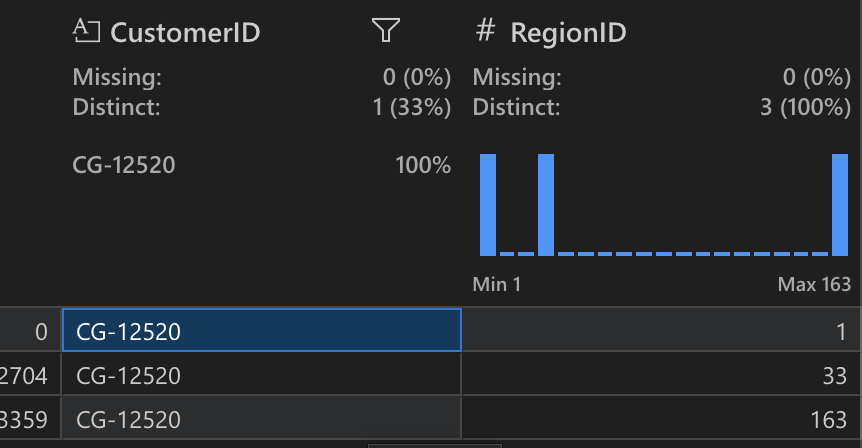

same customer ID can be linked to different addresses and viceversa

### Populate Categories

In [12]:
# Create unique category + subcategory + code
categories_df = superstore_df[['Category', 'Sub-Category']].drop_duplicates()
categories_df['CategoryCode'] = categories_df['Category'].str[:3].str.upper() + '-' + categories_df['Sub-Category'].str[:2].str.upper()
categories_df = categories_df.rename(columns={
    'Category': 'CategoryName',
    'Sub-Category': 'SubCategoryName'
})

categories_df.to_sql('Categories', conn, if_exists='append', index=False)

17

In [13]:
# verify categories table
categories_sql = pd.read_sql_query("SELECT * FROM Categories", conn)
categories_sql

,CategoryID,CategoryName,SubCategoryName,CategoryCode
0,1,Furniture,Bookcases,FUR-BO
1,2,Furniture,Chairs,FUR-CH
2,3,Office Supplies,Labels,OFF-LA
3,4,Furniture,Tables,FUR-TA
4,5,Office Supplies,Storage,OFF-ST
5,6,Furniture,Furnishings,FUR-FU
6,7,Office Supplies,Art,OFF-AR
7,8,Technology,Phones,TEC-PH
8,9,Office Supplies,Binders,OFF-BI
9,10,Office Supplies,Appliances,OFF-AP


### Populate Products

In [21]:
products_df = superstore_df[['Product_ID', 'Product_Name', 'Category', 'Sub-Category']].drop_duplicates()
products_df['CategoryCode'] = products_df['Category'].str[:3].str.upper() + '-' + products_df['Sub-Category'].str[:2].str.upper()

products_df = products_df.rename(columns={
    'Product_ID': 'ProductID',
    'Product_Name': 'ProductName'
})[['ProductID', 'ProductName', 'CategoryCode']]

products_df.to_sql('Products', conn, if_exists='replace', index=False)


1894

if_exists='append' adds new rows without checking for duplicates. So each time you run it, all the same rows get re-inserted, causing:

- duplicate data

- UNIQUE constraint errors (if primary keys exist)

Alternatives:
1. Overwrite Table Each Time (Good for Dev)
products_df.to_sql('Products', conn, if_exists='replace', index=False)
- Drops and recreates the table every time
- Ensures no duplicates
- ⚠️ Loses previously inserted data

2. Append Only New Records

Get existing ProductIDs from the database
existing_ids = pd.read_sql("SELECT ProductID FROM Products", conn)['ProductID']

Filter out duplicates
new_products_df = products_df[~products_df['ProductID'].isin(existing_ids)]

Append only new ones
new_products_df.to_sql('Products', conn, if_exists='append', index=False)

### Populate Shipping

In [ ]:
# drop duplicates in products table
shipping_df = superstore_df[['Ship_Mode', 'Ship_Date']].drop_duplicates()

# rename columns for consistency
shipping_df = shipping_df.rename(columns={
    'Ship_Mode': 'ShipMode',
    'Ship_Date': 'ShipDate'
})

# upload to SQL
shipping_df.to_sql('Shipping', conn, if_exists='append', index=False)

# Get ShipID for join
shipping_sql = pd.read_sql_query("SELECT * FROM Shipping", conn)


In [ ]:
# verify shipping table
shipping_sql

,ShipID,ShipMode,ShipDate
0,1,Second Class,2016-11-11
1,2,Second Class,2016-06-16
2,3,Standard Class,2015-10-18
3,4,Standard Class,2014-06-14
4,5,Standard Class,2017-04-20
...,...,...,...
2603,2604,Same Day,2015-07-26
2604,2605,First Class,2017-08-06
2605,2606,Standard Class,2015-05-23
2606,2607,Second Class,2014-01-23


### Populate Orders 

In [ ]:
# drop duplicates in orders table
orders_df = superstore_df[['Order_ID', 'Order_Date', 'Customer_ID', 'Ship_Mode', 'Ship_Date']].drop_duplicates()

# rename columns for consistency
orders_df = orders_df.rename(columns={
    'Order_ID': 'OrderID',
    'Order_Date': 'OrderDate',
    'Customer_ID': 'CustomerID',
    'Ship_Mode': 'ShipMode',
    'Ship_Date': 'ShipDate'
})

# Add ShipID by merging with shipping table
orders_df = orders_df.merge(shipping_sql, on=['ShipMode', 'ShipDate'], how='left')[['OrderID', 'OrderDate', 'CustomerID', 'ShipID']]

# upload to SQL
orders_df.to_sql('Orders', conn, if_exists='append', index=False)


5009

### Populate OrderDetails

In [ ]:
# drop duplicates in order details table
orderdetails_df = superstore_df[['Order_ID', 'Product_ID', 'Sales', 'Quantity', 'Discount', 'Profit']]

#rename columns for consistency
orderdetails_df = orderdetails_df.rename(columns={
    'Order_ID': 'OrderID',
    'Product_ID': 'ProductID'
})

#upload to SQL
orderdetails_df.to_sql('OrderDetails', conn, if_exists='append', index=False)


9994